In [1]:
import numpy as np
from itertools import product

import matplotlib.pyplot as plt

%matplotlib inline

##### Exercise 6.6 and 6.7, Windy grid world

It takes a lot longer for my SARSA to converge than the one in the book at 8000 time steps with $\alpha = 0.1$. Looking around on the internet, it seems very likely that Figure 6.11 was done with $\alpha = 0.5$ (see https://www.cse.iitb.ac.in/~sushantcse/Articles/Analysis_of_SARSA_on_Windy_Gridworld.pdf and the plots below). 


In [129]:

class WindyGridWorld(object):
    def __init__(self, grid, wind, stochastic_wind=False):
        """
            1: valid move
            2: start
            3: end
        """
        self.grid = grid
        self.wind = wind
        self.wind_is_stochastic = stochastic_wind
        self.row = 0
        self.column = 0
    
    def set_starting_state(self):
        w = np.where(self.grid == 2)
        self.row = w[0][0]
        self.column = w[1][0]
    
    def take_action(self, action):
        reward = -1
        random_wind = 0

        if self.wind_is_stochastic:
            random_wind = np.random.choice([-1, 0, 1], size=1, p=[1/3., 1/3., 1/3.])[0]
        
        # apply action
        d_row, d_column = action
        new_row = d_row + self.row
        new_column = d_column + self.column
        if not self.is_out_of_bounds(new_row, new_column):
            
            # apply wind        
            new_row_w_wind = new_row - self.wind[self.column] + random_wind
            if not self.is_out_of_bounds(new_row_w_wind, new_column):
                new_row = new_row_w_wind
            
            self.row = new_row
            self.column = new_column
        
        return reward
    
    def get_state(self):
        return (self.row, self.column)
    
    def get_states(self):
        return list(product(range(self.grid.shape[0]), range(self.grid.shape[1])))
    
    def is_terminal_state(self):
        if self.grid[self.row, self.column] == 3:
            return True
        return False
    
    def is_out_of_bounds(self, r, c):
        if r < 0 or r > self.grid.shape[0] - 1:
            return True
        
        if c < 0 or c > self.grid.shape[1] - 1:
            return True
        
        return False
    
    def get_regular_actions(self):
        return [(1, 0), (-1, 0), (0, 1), (0, -1)]
    
    def get_kings_actions(self):
        return list(set(product([-1, 0, 1], [-1, 0, 1])) - set([(0, 0)]))


In [130]:
class Solver(object):
    def __init__(self, environment, actions):
        self.environment = environment
        self.actions = actions
        self.states = environment.get_states()
        self.state_idx = {s: idx for idx, s in enumerate(self.states)}
        self.Q = np.random.random(size=(len(self.states), len(self.actions)))
        
    def SARSA(self, max_time_steps=8000, epsilon=0.1, alpha=0.1, gamma=1):
        self.Q = np.zeros((len(self.states), len(self.actions)))
        
        t = 0
        episode_history = [0]
        while t < max_time_steps:
            episode_history.append(episode_history[-1] + 1)
            self.environment.set_starting_state()
            s = self.environment.get_state()
            a = self.get_epsilon_greedy_action(s, epsilon)

            while not self.environment.is_terminal_state() and t < max_time_steps:
                episode_history.append(episode_history[-1])
                r = self.environment.take_action(self.actions[a])
                s_prime = self.environment.get_state()
                a_prime = self.get_epsilon_greedy_action(s_prime, epsilon)
                self.Q[self.state_idx[s], a] += alpha * (r + gamma * self.Q[self.state_idx[s_prime], a_prime] \
                                                         - self.Q[self.state_idx[s], a])
                s = s_prime; a = a_prime
                t += 1

        return episode_history
            
    def get_epsilon_greedy_action(self, s, epsilon=0.1):
        s_idx = self.state_idx[s]
        u_rand = np.random.random()
        if u_rand < epsilon:
            return np.random.randint(low=0, high=len(self.actions))
        action_idx = np.where(self.Q[s_idx,:] == np.amax(self.Q[s_idx,:]))[0]
        return np.random.choice(action_idx)
    
    def get_greedy_episode(self, max_iter=20):
        self.environment.set_starting_state()
        s = self.environment.get_state()

        g_orig = self.environment.grid
        g = np.copy(g_orig)
        g[s[0], s[1]] = -1
        print(g)
    
        t = 0
        while not self.environment.is_terminal_state() and t < max_iter:
            a = self.get_epsilon_greedy_action(s, epsilon=0)
            print('taking action', a)
            r = self.environment.take_action(self.actions[a])
            s = self.environment.get_state()
            g = np.copy(g_orig)
            g[s[0], s[1]] = -1
            print(g)
            t += 1


In [131]:
grid = np.array([
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 1, 1, 1, 1, 1, 1, 3, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    ])
wind = np.array([0, 0, 0, 1, 1, 1, 2, 2, 1, 0])

In [132]:

max_time_step = 24000 # it takes longer to converge with alpha = 0.1

# Regular Wind
gw = WindyGridWorld(grid, wind, stochastic_wind=False)

solver = Solver(gw, gw.get_regular_actions())
num_episodes_regular = solver.SARSA(max_time_steps=max_time_step, alpha=0.1)
solver = Solver(gw, gw.get_kings_actions())
num_episodes_kings = solver.SARSA(max_time_steps=max_time_step, alpha=0.1)

# Stochastic Wind
gw = WindyGridWorld(grid, wind, stochastic_wind=True)

solver = Solver(gw, gw.get_regular_actions())
num_episodes_regular_stochastic = solver.SARSA(max_time_steps=max_time_step, alpha=.1)
solver = Solver(gw, gw.get_kings_actions())
num_episodes_kings_stochastic = solver.SARSA(max_time_steps=max_time_step, alpha=.1)


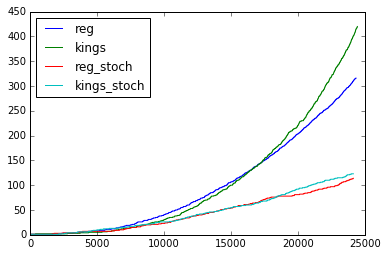

In [133]:
plt.plot(num_episodes_regular)
plt.plot(num_episodes_kings)
plt.plot(num_episodes_regular_stochastic)
plt.plot(num_episodes_kings_stochastic)
plt.legend(['reg', 'kings', 'reg_stoch', 'kings_stoch'], loc='best')

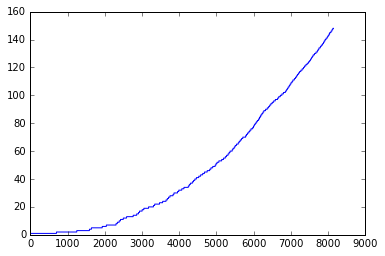

In [134]:
# With alpha = 0.5 and 8000 time steps, the plot is identical to the one in the book
gw = WindyGridWorld(grid, wind, stochastic_wind=False)
solver = Solver(gw, gw.get_regular_actions())
num_episodes_regular = solver.SARSA(max_time_steps=8000, alpha=0.5)
plt.plot(num_episodes_regular)

In [135]:
solver.get_greedy_episode()

[[ 1  1  1  1  1  1  1  1  1  1]
 [ 1  1  1  1  1  1  1  1  1  1]
 [ 1  1  1  1  1  1  1  1  1  1]
 [-1  1  1  1  1  1  1  3  1  1]
 [ 1  1  1  1  1  1  1  1  1  1]
 [ 1  1  1  1  1  1  1  1  1  1]
 [ 1  1  1  1  1  1  1  1  1  1]]
('taking action', 1)
[[ 1  1  1  1  1  1  1  1  1  1]
 [ 1  1  1  1  1  1  1  1  1  1]
 [-1  1  1  1  1  1  1  1  1  1]
 [ 2  1  1  1  1  1  1  3  1  1]
 [ 1  1  1  1  1  1  1  1  1  1]
 [ 1  1  1  1  1  1  1  1  1  1]
 [ 1  1  1  1  1  1  1  1  1  1]]
('taking action', 2)
[[ 1  1  1  1  1  1  1  1  1  1]
 [ 1  1  1  1  1  1  1  1  1  1]
 [ 1 -1  1  1  1  1  1  1  1  1]
 [ 2  1  1  1  1  1  1  3  1  1]
 [ 1  1  1  1  1  1  1  1  1  1]
 [ 1  1  1  1  1  1  1  1  1  1]
 [ 1  1  1  1  1  1  1  1  1  1]]
('taking action', 2)
[[ 1  1  1  1  1  1  1  1  1  1]
 [ 1  1  1  1  1  1  1  1  1  1]
 [ 1  1 -1  1  1  1  1  1  1  1]
 [ 2  1  1  1  1  1  1  3  1  1]
 [ 1  1  1  1  1  1  1  1  1  1]
 [ 1  1  1  1  1  1  1  1  1  1]
 [ 1  1  1  1  1  1  1  1  1  1]]
('taking 